In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pathlib
import glob
import cv2
import numpy as np
import torch.tensor
import torchvision.datasets as dset
import random

In [ ]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#hyper parameters
#input_size = 180
num_classes = 2
num_epochs = 10
batch_size = 16
learning_rate = 0.001
workers=0

In [ ]:
#dataloader

train_path = '/content/drive/MyDrive/Heritage/train'

dataset = dset.ImageFolder(root=train_path,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


test_path = '/content/drive/MyDrive/Heritage/test'

dataset1 = dset.ImageFolder(root=test_path,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

test_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


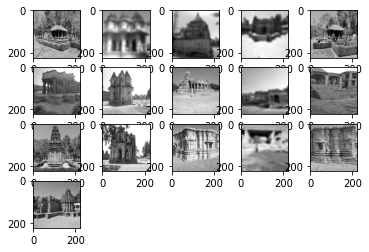

In [ ]:
examples = iter(train_loader)
example_data, example_targets = examples.next()

for i in range(16):
   plt.subplot(4, 5, i+1)
   plt.imshow(example_data[i][0], cmap='gray')
plt.show()


In [ ]:
root=pathlib.Path(test_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['blur', 'sharp']


In [ ]:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [ ]:
def conv_block1(inc,outc,ks,s,p):
  x=nn.Sequential(
      nn.Conv2d(in_channels=inc,out_channels=3*outc,kernel_size=ks,stride=s,padding=p),
      nn.Conv2d(in_channels=3*outc,out_channels=9*outc,kernel_size=ks,stride=s,padding=p),
      nn.Conv2d(in_channels=9*outc,out_channels=27*outc,kernel_size=ks,stride=s,padding=p),
      nn.BatchNorm2d(27*outc),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
      )
  
  return x

def conv_block2(inc,outc,ks,s,p):
  x=nn.Sequential(
      nn.Conv2d(in_channels=3*outc,out_channels=9*outc,kernel_size=ks,stride=s,padding=p),
      nn.Conv2d(in_channels=27*inc,out_channels=27*outc,kernel_size=ks,stride=s,padding=p),
      nn.Conv2d(in_channels=81*inc,out_channels=81*outc,kernel_size=ks,stride=s,padding=p),
      nn.BatchNorm2d(81*outc),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
      
      )
  return x

def conv_block3(inc,outc,ks,s,p):
    x=nn.Sequential(
      nn.Conv2d(in_channels=27*outc,out_channels=27*outc,kernel_size=ks-2,stride=s,padding=p-1),
      nn.BatchNorm2d(27*outc),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
      )
    return x

"""def conv_block4(inc,outc,ks,s,p):
    x=nn.Sequential(
      nn.Conv2d(in_channels=9*outc,out_channels=27*outc,kernel_size=ks,stride=s,padding=p),
      nn.BatchNorm2d(27*outc),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
      )
    return x
"""


class net(nn.Module):
  def __init__(self,num_classes):
    super(net,self).__init__()
    self.block1=conv_block1(3,3,3,2,1)
    self.block2=conv_block2(9,27,3,2,2)
    self.block3=conv_block3(27,81,3,3,2)
    #self.block4=conv_block4(81,243,3,3,2)
    self.classifier=nn.Sequential(
        nn.Linear(1*1*2187, 729),
        nn.Dropout(0.2),
        nn.ReLU(True),
        nn.Linear(729, 243),
        nn.Dropout(0.2),
        nn.ReLU(True),
        nn.Linear(243, 81),
        nn.Dropout(0.2),
        nn.ReLU(True),
        nn.Linear(81, 27),
        nn.Dropout(0.2),
        nn.ReLU(True),
        nn.Linear(27, num_classes),
        #nn.ReLU(num_classes)
    )

  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    #x=self.block4(x)
    #print(x.shape)
    x=x.reshape(x.shape[0],-1)
    x=self.classifier(x)
    return x
    #x=torch.nn.functional.softmax(x, dim=0, _stacklevel=3, dtype=None)
model=net(3).to(device=device)
print(model)
    

net(
  (block1): Sequential(
    (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(9, 27, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(27, 81, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(81, 243, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(243, 729, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (2): Conv2d(729, 2187, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(2187, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(2187, 2187, kernel_siz

In [ ]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#PATH = "model.pth.tar"
#def save_checkpoint(ch,path=PATH):
#torch.save(ch,path)



In [ ]:
#train the model
manualSeed=1
np.random.seed(manualSeed)
random.seed(manualSeed)
best_accuracy=0.0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):


     for i, (images, labels) in enumerate(train_loader):
           images = images.to(device)
           labels = labels.to(device)
           



        # forward
           outputs = model(images)
           loss = criterion(outputs, labels)
         
         #backward
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()

           if(i+1) % 100 == 0:
              print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
                  


epoch 1 / 10, step 100/150, loss = 0.7087
epoch 2 / 10, step 100/150, loss = 0.6977
epoch 3 / 10, step 100/150, loss = 0.6954
epoch 4 / 10, step 100/150, loss = 0.6734
epoch 5 / 10, step 100/150, loss = 0.7094
epoch 6 / 10, step 100/150, loss = 0.7052
epoch 7 / 10, step 100/150, loss = 0.6961
epoch 8 / 10, step 100/150, loss = 0.6997
epoch 9 / 10, step 100/150, loss = 0.6934
epoch 10 / 10, step 100/150, loss = 0.6964


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        #print(n_samples, n_correct)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test images: {acc} %')

Accuracy of the network on test images: 50.0 %
